In [181]:
import os
import json
import pytz
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Bigquery
from google.cloud import bigquery

try:
    from mlutils import dataset, connector # Element environment connectors
    APP_PATH = '/home/jupyter/automation/inhome/'
except ImportError:
    APP_PATH = ""
    
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
def get_config(APP_PATH, config_file):
    '''Return config file'''
    config_path = os.path.join(APP_PATH, config_file)
    with open(config_path, 'r') as file:
        config = json.load(file)
    return config


def get_data(config):
    '''Read data from BigQuery table given in config file'''
    table_id = config['bq_table_nm']
    bq_conn = config['bq_connector']
    job_config = bigquery.QueryJobConfig()
    
    try:
        client = connector.get_connector(name=bq_conn)
    except:
        client = bigquery.Client()

    try:
        query = f"SELECT * FROM `{table_id}`"
        query_job = client.query(query, job_config=job_config)

        # Get the result
        df = query_job.to_dataframe()

        log_body = "Data read at: "+datetime.now(pytz.timezone('America/Los_Angeles')).strftime("%Y-%m-%d %H:%M:%S")+" PT"
        return (True, df, log_body)
    except Exception as e:
        log_body = table_id + " - Read Error: " + str(e)
        return (False, None, log_body)

In [3]:
config = get_config(APP_PATH, "config.json")

In [168]:
is_success, df, log_body = get_data(config)

C:\Users\y0q00wv\Anaconda3\lib\site-packages\google\auth\_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602766 entries, 0 to 602765
Data columns (total 32 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   DRVR_USER_ID                            602766 non-null  object        
 1   driver_tenure_day                       602766 non-null  int64         
 2   DRVR_RATG_NBR                           602766 non-null  object        
 3   DEACTIVATION_TYPE_NM                    602766 non-null  object        
 4   DEACTIVATION_RSN_NM                     108250 non-null  object        
 5   LAST_ACTIVATED_TS                       602766 non-null  datetime64[ns]
 6   LAST_DEATVD_TS                          109464 non-null  datetime64[ns]
 7   total_order_cnt                         602766 non-null  int64         
 8   total_po_cnt                            602766 non-null  int64         
 9   total_trip_cnt                       

In [170]:
df.isnull().sum() / df.shape[0]

DRVR_USER_ID                              0.000000
driver_tenure_day                         0.000000
DRVR_RATG_NBR                             0.000000
DEACTIVATION_TYPE_NM                      0.000000
DEACTIVATION_RSN_NM                       0.820411
LAST_ACTIVATED_TS                         0.000000
LAST_DEATVD_TS                            0.818397
total_order_cnt                           0.000000
total_po_cnt                              0.000000
total_trip_cnt                            0.000000
total_accpt_trip_cnt                      0.000000
total_item_qty                            0.000000
MISSING_ITEM_QTY                          0.000000
ordered_dollar_value                      0.000000
MISSING_ITEM_DOLLAR_VALUE                 0.000000
missing_po_cnt                            0.000000
same_cust_email_trip_cnt                  0.000000
same_cust_phone_trip_cnt                  0.000000
large_pay_amt_cnt                         0.000000
max_freq_amt                   

### Clean Data

In [216]:
def clean_data(df, reasons = ['Shared Account', 'Critical', 'Behavior', 'The driver has been Reinstated', 'Automatic']):
    # drop drivers with no trips
    df = df[df['total_trip_cnt'] != 0]
    # deal with total_po_cnt == 0
    # fill with missing_po_cnt first, if missing_po_cnt > 0, then missing_po_pct would be 1
    df.loc[df['total_po_cnt'] == 0, 'total_po_cnt'] = df[df['total_po_cnt'] == 0]['missing_po_cnt']
    # if still 0, then both missing_po_cnt and total_po_cnt are 0, fill with 1 (placholder), so missing_po_pct will be 0
    df.loc[df['total_po_cnt'] == 0, 'total_po_cnt'] = 1
    
    # data type convert
    type_conv = CONFIG['data_type_convert']
    for col, dtype in type_conv.items():
        if dtype == 'datetime64[ns]':
            df[col] = pd.to_datetime(df[col].fillna(pd.NaT), errors='coerce')
            df[col] = df[col].dt.date # save as date in BigQuery table, other than timestamp
        else:
            df[col] = df[col].astype(dtype)
    
    # deactivate flag within data time range, exluding deleted accounts (likely voluntarily deleted)
    df['deactivated'] = ((df.LAST_DEATVD_TS >= df.data_start_dt_pt) &
                         (df.LAST_DEATVD_TS <= df.data_end_dt_pt) & 
                        (df.DEACTIVATION_TYPE_NM != 'DELETED')) * 1
    
    # create separate column for top deactivation reasons
    for reason in reasons:
        df[reason] = ((df['DEACTIVATION_RSN_NM'] == reason) & (df['deactivated'] == 1)).astype(int)
    
    # create ratio columns
    mapping = {
        'total_po_cnt':['missing_po_cnt'],
        'total_trip_cnt':[
            'same_cust_email_trip_cnt', 
            'same_cust_phone_trip_cnt',
            'large_pay_amt_cnt', 
            'max_freq_amt_cnt',
            'drop_after_arrived_at_store_trip_cnt',
            # existing model metrics
            'swipe_abuse_trip_cnt', 
            'return_abuse_trip_cnt', 
            'scan_abuse_trip_cnt',
            'drop_abuse_trip_cnt', 
            'multi_drop_abuse_trip_cnt',
            'prop_22_abuse_trip_cnt', 
            'shop_n_deliver_nil_pick_abuse_trip_cnt'
        ],
        'total_accpt_trip_cnt': ['express_accpt_trip_cnt'],
        'total_item_qty': ['missing_item_cnt']
    }
    
    for level in mapping.keys():
        for metric in mapping[level]:
            df[f'{metric[:-4]}_pct'] = df[metric] / df[level]
            
    return df

In [199]:
df = clean_data(df)

In [76]:
# Pending confirmation from stakeholder
'''
fraud_rsn_lst = ['Critical', 'Shared Account', 'Automatic']
df['is_fraud'] = df['DEACTIVATION_RSN_NM'].isin(fraud_rsn_lst) * 1
'''

In [31]:
df[['missing_po_pct', 'missing_item_pct', 'same_cust_email_trip_pct',
       'same_cust_phone_trip_pct', 'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct']].describe()

,missing_po_pct,missing_item_pct,same_cust_email_trip_pct,same_cust_phone_trip_pct,large_pay_amt_pct,max_freq_amt_pct,drop_after_arrived_at_store_trip_pct,express_accpt_trip_pct
count,601003.000000,574180.000000,601003.000000,601003.000000,601003.000000,601003.000000,601003.000000,601003.000000
mean,0.005625,0.006289,0.000543,0.000644,0.045886,0.079481,0.006361,0.001666
std,0.019993,0.031025,0.015436,0.016748,0.094048,0.100726,0.036110,0.017071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000244,0.000000,0.000000,0.013986,0.058201,0.000000,0.000000
75%,0.006510,0.004445,0.000000,0.000000,0.051948,0.122530,0.001818,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Visualize key features

In [13]:
def plot_feature_hist(df, feature, upper_bound=None, bins='auto', quantile=0.95, lower_bound=0):
    '''Plot histogram for a feature, within given range, and print given quantile of this feature'''
    if upper_bound is None:
        upper_bound = df[feature].max()
    
    sns.histplot(df[feature], bins=bins, binrange=(lower_bound, upper_bound))
        
    plt.title(f"Histogram of {feature}, data range {lower_bound} to {upper_bound}")
    plt.show()
    
    print(f"{quantile * 100}% percentile of {feature} is {df[feature].quantile(quantile)}")

#### missing_po_cnt

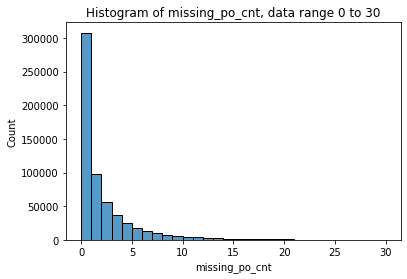

95.0% percentile of missing_po_cnt is 9.0


In [14]:
plot_feature_hist(df, 'missing_po_cnt', 30, 30)

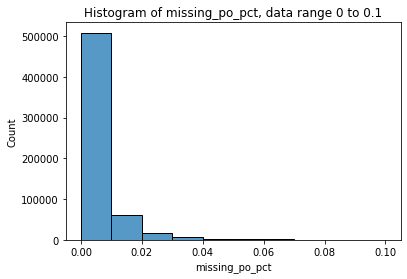

95.0% percentile of missing_po_pct is 0.020833333333333332


In [15]:
plot_feature_hist(df, 'missing_po_pct', 0.1, 10)

#### missing_item_cnt

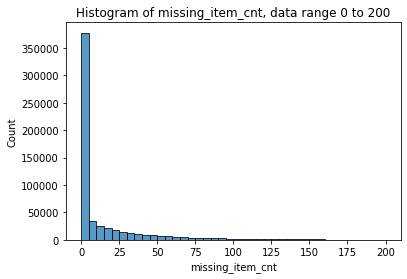

95.0% percentile of missing_item_cnt is 88.0


In [34]:
plot_feature_hist(df, 'missing_item_cnt', upper_bound=200, bins=40)

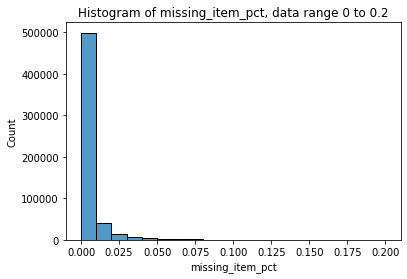

95.0% percentile of missing_item_pct is 0.02345107351553986


In [36]:
plot_feature_hist(df, 'missing_item_pct', upper_bound=0.2, bins=20)

#### same_cust_email_trip_cnt

In [174]:
df['same_cust_email_trip_cnt'].describe()

count    604547.000000
mean          0.040625
std           0.837796
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         160.000000
Name: same_cust_email_trip_cnt, dtype: float64

In [179]:
df.sort_values('same_cust_email_trip_cnt', ascending=False).head(10)[['DRVR_USER_ID', 'LAST_DEATVD_TS', 'same_cust_email_trip_cnt']]

,DRVR_USER_ID,LAST_DEATVD_TS,same_cust_email_trip_cnt
502248,djteero5752@gmail.com,NaT,160
433108,jimmywhite073@gmail.com,2023-07-22 16:18:24.747,158
52150,haleigh_martin70511@hotmail.com,NaT,154
470543,detonate321@msn.com,2024-10-02 12:51:28.603,154
505313,dee1551@hotmail.com,NaT,133
518967,jeremiahboyer@gmail.com,NaT,129
591222,clyde3218@gmail.com,2024-09-25 06:37:17.417,120
5832,5monstahs@gmail.com,NaT,84
434144,sean.thompson.t@gmail.com,NaT,79
478408,jonhull289@hotmail.com,NaT,77


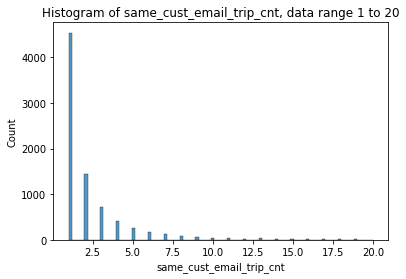

95.0% percentile of same_cust_email_trip_cnt is 0.0


In [219]:
plot_feature_hist(df, 'same_cust_email_trip_cnt', lower_bound=1, upper_bound=20)

#### same_cust_phone_trip_cnt

In [216]:
df['same_cust_phone_trip_cnt'].describe()

count    604547.000000
mean          0.047265
std           0.884605
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         160.000000
Name: same_cust_phone_trip_cnt, dtype: float64

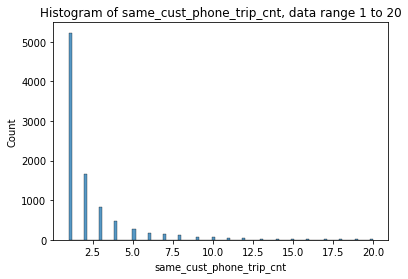

95.0% percentile of same_cust_phone_trip_cnt is 0.0


In [217]:
plot_feature_hist(df, 'same_cust_phone_trip_cnt', lower_bound=1, upper_bound=20)

#### large_pay_amt_cnt

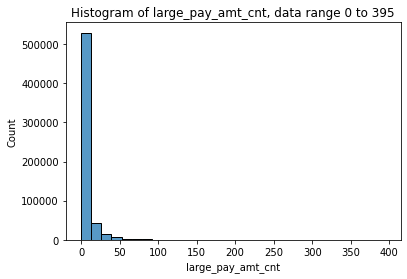

95.0% percentile of large_pay_amt_cnt is 26.0


In [38]:
plot_feature_hist(df, 'large_pay_amt_cnt', bins=30)

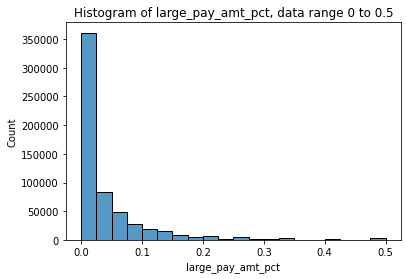

95.0% percentile of large_pay_amt_pct is 0.19480519480519481


In [40]:
plot_feature_hist(df, 'large_pay_amt_pct', upper_bound=0.5, bins=20)

#### max_freq_amt_pct

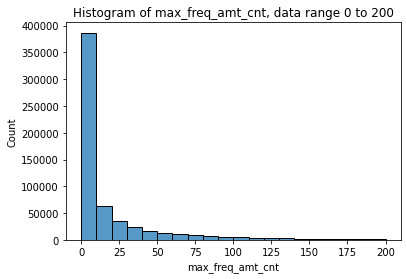

95.0% percentile of max_freq_amt_cnt is 103.0


In [43]:
plot_feature_hist(df, 'max_freq_amt_cnt', upper_bound=200, bins=20)

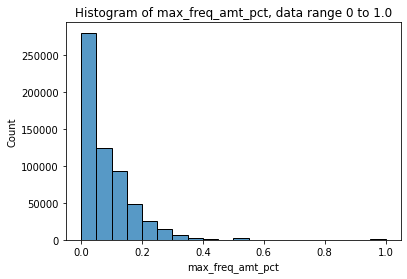

95.0% percentile of max_freq_amt_pct is 0.25


In [41]:
plot_feature_hist(df, 'max_freq_amt_pct', bins=20)

#### drop_after_arrived_at_store_trip_cnt

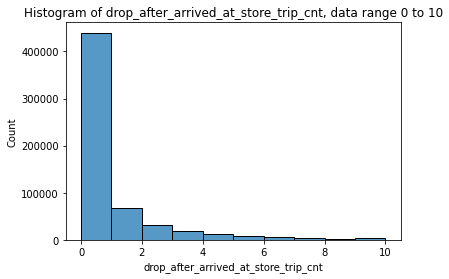

95.0% percentile of drop_after_arrived_at_store_trip_cnt is 5.0


In [82]:
plot_feature_hist(df, 'drop_after_arrived_at_store_trip_cnt', upper_bound=10, bins=10)

#### express_accpt_trip_pct

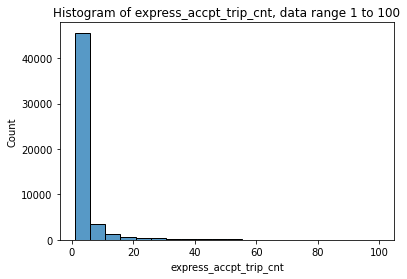

95.0% percentile of express_accpt_trip_cnt is 1.0


In [70]:
plot_feature_hist(df, 'express_accpt_trip_cnt', lower_bound=1, upper_bound=100, bins=20)

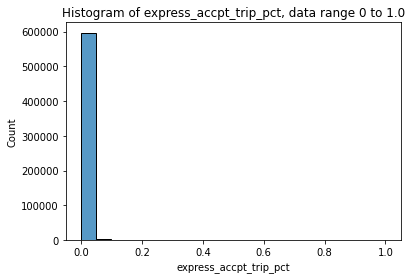

95.0% percentile of express_accpt_trip_pct is 0.004032258064516129


In [67]:
plot_feature_hist(df, 'express_accpt_trip_pct', bins=20)

#### existing model features

In [64]:
df[['swipe_abuse_trip_pct',
       'return_abuse_trip_pct', 'scan_abuse_trip_pct', 'drop_abuse_trip_pct',
       'multi_drop_abuse_trip_pct', 'prop_22_abuse_trip_pct',
       'shop_n_deliver_nil_pick_abuse_trip_pct']].describe()

,swipe_abuse_trip_pct,return_abuse_trip_pct,scan_abuse_trip_pct,drop_abuse_trip_pct,multi_drop_abuse_trip_pct,prop_22_abuse_trip_pct,shop_n_deliver_nil_pick_abuse_trip_pct
count,601003.000000,601003.000000,601003.000000,601003.000000,601003.000000,601003.000000,601003.000000
mean,0.000060,0.000021,0.001249,0.016281,0.019852,0.000204,0.002309
std,0.003296,0.002199,0.017171,0.058469,0.074715,0.008664,0.021254
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.014085,0.015528,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


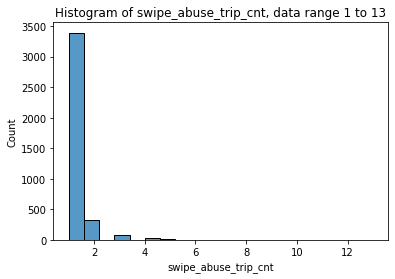

95.0% percentile of swipe_abuse_trip_cnt is 0.0


In [47]:
plot_feature_hist(df, 'swipe_abuse_trip_cnt', lower_bound=1, bins=20)

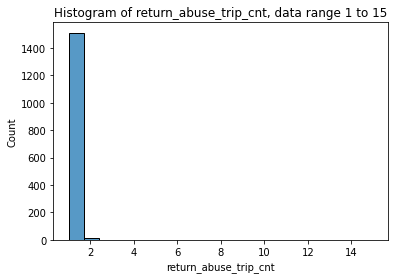

95.0% percentile of return_abuse_trip_cnt is 0.0


In [49]:
plot_feature_hist(df, 'return_abuse_trip_cnt', lower_bound=1, bins=20)

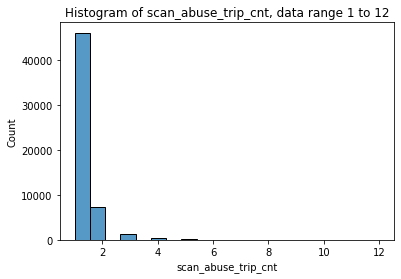

95.0% percentile of scan_abuse_trip_cnt is 1.0


In [50]:
plot_feature_hist(df, 'scan_abuse_trip_cnt', lower_bound=1, bins=20)

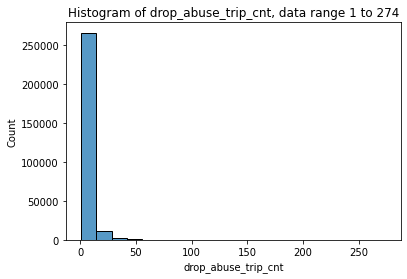

95.0% percentile of drop_abuse_trip_cnt is 10.0


In [52]:
plot_feature_hist(df, 'drop_abuse_trip_cnt', lower_bound=1, bins=20)

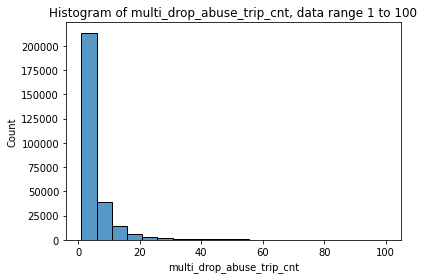

95.0% percentile of multi_drop_abuse_trip_cnt is 11.0


In [54]:
plot_feature_hist(df, 'multi_drop_abuse_trip_cnt', lower_bound=1, upper_bound=100, bins=20)

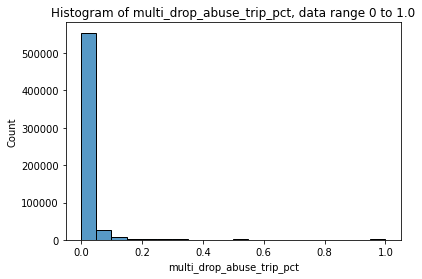

95.0% percentile of multi_drop_abuse_trip_pct is 0.07142857142857142


In [55]:
plot_feature_hist(df, 'multi_drop_abuse_trip_pct', bins=20)

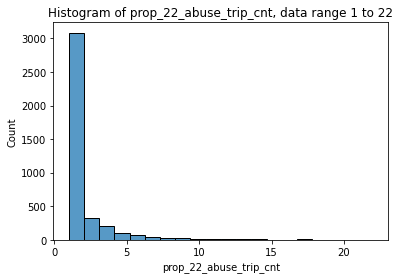

95.0% percentile of prop_22_abuse_trip_cnt is 0.0


In [58]:
plot_feature_hist(df, 'prop_22_abuse_trip_cnt', lower_bound=1, bins=20)

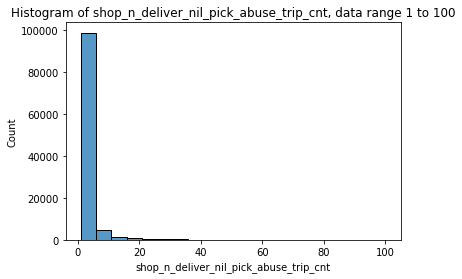

95.0% percentile of shop_n_deliver_nil_pick_abuse_trip_cnt is 2.0


In [63]:
plot_feature_hist(df, 'shop_n_deliver_nil_pick_abuse_trip_cnt', lower_bound=1, upper_bound=100, bins=20)

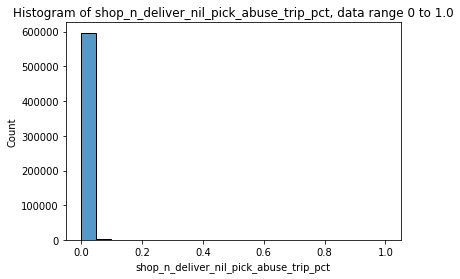

95.0% percentile of shop_n_deliver_nil_pick_abuse_trip_pct is 0.0081799591002045


In [62]:
plot_feature_hist(df, 'shop_n_deliver_nil_pick_abuse_trip_pct', bins=20)

In [37]:
df.columns

Index(['DRVR_USER_ID', 'driver_tenure_day', 'DRVR_RATG_NBR',
       'DEACTIVATION_TYPE_NM', 'DEACTIVATION_RSN_NM', 'LAST_ACTIVATED_TS',
       'LAST_DEATVD_TS', 'total_order_cnt', 'total_po_cnt', 'total_trip_cnt',
       'total_accpt_trip_cnt', 'total_item_qty', 'MISSING_ITEM_QTY',
       'ordered_dollar_value', 'MISSING_ITEM_DOLLAR_VALUE', 'missing_po_cnt',
       'same_cust_email_trip_cnt', 'same_cust_phone_trip_cnt',
       'large_pay_amt_cnt', 'max_freq_amt', 'max_freq_amt_cnt',
       'drop_after_arrived_at_store_trip_cnt', 'express_accpt_trip_cnt',
       'swipe_abuse_trip_cnt', 'return_abuse_trip_cnt', 'scan_abuse_trip_cnt',
       'drop_abuse_trip_cnt', 'multi_drop_abuse_trip_cnt',
       'prop_22_abuse_trip_cnt', 'shop_n_deliver_nil_pick_abuse_trip_cnt',
       'missing_po_pct', 'same_cust_email_trip_pct',
       'same_cust_phone_trip_pct', 'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'swipe_abuse_trip_pct',
       'return_abuse_trip_

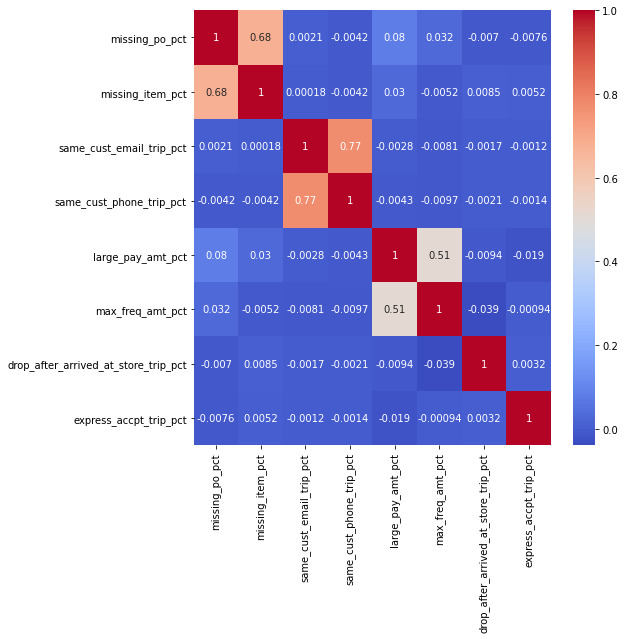

In [80]:
feature_cols = ['missing_po_pct', 'missing_item_pct', 'same_cust_email_trip_pct',
       'same_cust_phone_trip_pct', 'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct']

corr_matrix = df[feature_cols].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

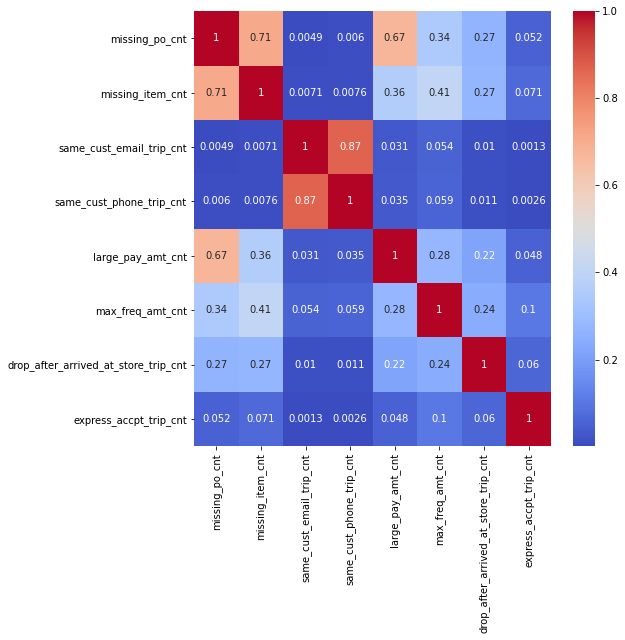

In [79]:
test_feature_cols = ['missing_po_cnt', 'missing_item_cnt', 'same_cust_email_trip_cnt',
       'same_cust_phone_trip_cnt', 'large_pay_amt_cnt', 'max_freq_amt_cnt',
       'drop_after_arrived_at_store_trip_cnt', 'express_accpt_trip_cnt']

corr_matrix = df[test_feature_cols].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

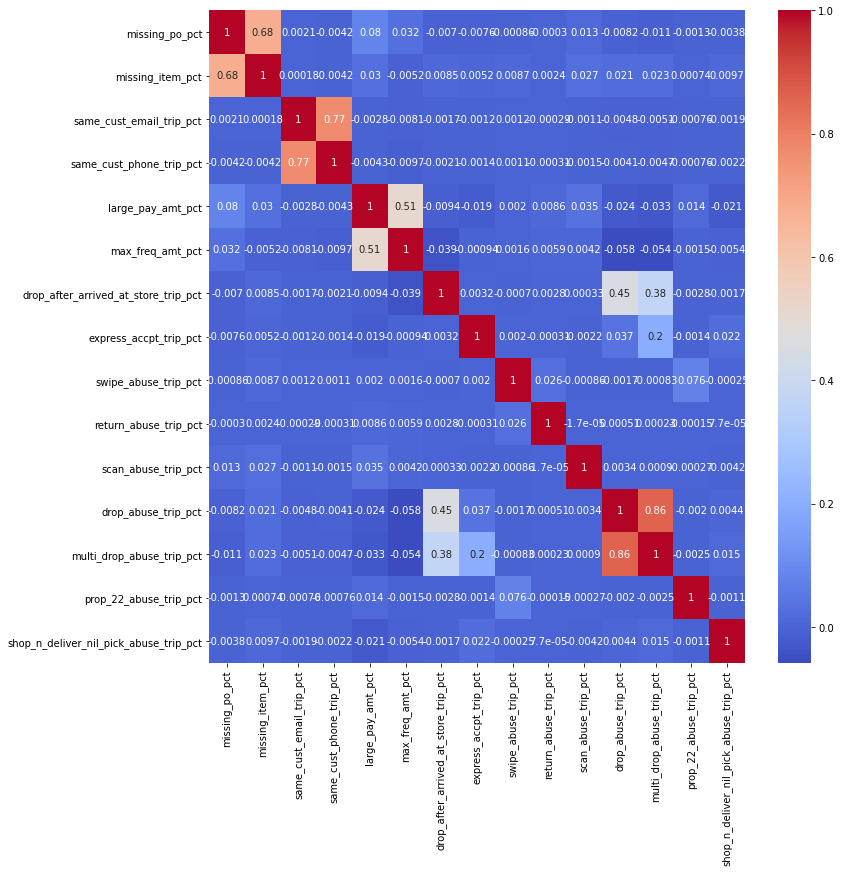

In [83]:
feature_cols2 = ['missing_po_pct', 'missing_item_pct', 'same_cust_email_trip_pct',
       'same_cust_phone_trip_pct', 'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct',
        'swipe_abuse_trip_pct', 
        'return_abuse_trip_pct', 
        'scan_abuse_trip_pct',
        'drop_abuse_trip_pct', 
        'multi_drop_abuse_trip_pct',
        'prop_22_abuse_trip_pct', 
        'shop_n_deliver_nil_pick_abuse_trip_pct']

corr_matrix2 = df[feature_cols2].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm');

## K-means model

### Only use new features

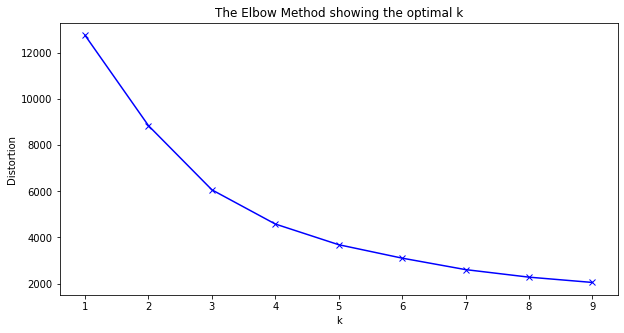

In [178]:
feature_cols =  ['missing_po_pct', 'same_cust_phone_trip_pct',
       'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct']

data = df[feature_cols]

distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    distortions.append(kmeans.inertia_)   # sum of squared distances to closest centroid for all observations

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [182]:
feature_cols =  ['missing_po_pct', 'same_cust_phone_trip_pct',
       'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct']

data = df[feature_cols]

# scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
kmeans = KMeans(n_clusters=4, random_state=42).fit(data_scaled)

df['driver_group_new_features'] = kmeans.labels_

silhouette_score_value = silhouette_score(data_scaled, kmeans.labels_, sample_size=30000, random_state=42)

print(f"silhouette score: {silhouette_score_value}")

silhouette score: 0.7349202266499552


In [209]:
output_cols = ['deactivated'] + reasons + ['driver_tenure_day', 
    'DRVR_RATG_NBR',
    'total_trip_cnt',
    'missing_item_cnt',
    'missing_item_pct',
    'missing_po_cnt',
    'missing_po_pct',
    'same_cust_email_trip_cnt',
    'same_cust_email_trip_pct',
    'same_cust_phone_trip_cnt',
    'same_cust_phone_trip_pct',
    'large_pay_amt_cnt',
    'large_pay_amt_pct',
    'max_freq_amt',
    'max_freq_amt_cnt',
    'max_freq_amt_pct',
    'drop_after_arrived_at_store_trip_cnt',
    'drop_after_arrived_at_store_trip_pct',
    'express_accpt_trip_cnt',
    'express_accpt_trip_pct',
    'swipe_abuse_trip_cnt',
    'return_abuse_trip_cnt',
    'scan_abuse_trip_cnt',
    'drop_abuse_trip_cnt',
    'multi_drop_abuse_trip_cnt',
    'prop_22_abuse_trip_cnt',
    'shop_n_deliver_nil_pick_abuse_trip_cnt',
    'swipe_abuse_trip_pct',
    'return_abuse_trip_pct',
    'scan_abuse_trip_pct',
    'drop_abuse_trip_pct',
    'multi_drop_abuse_trip_pct',
    'prop_22_abuse_trip_pct',
    'shop_n_deliver_nil_pick_abuse_trip_pct'
]

In [217]:
df.groupby('driver_group_new_features')[output_cols].mean().T.to_clipboard()

In [201]:
df.groupby('driver_group_new_features')[output_cols].median().T.to_clipboard()

In [184]:
df.groupby('driver_group_new_features')['DRVR_USER_ID'].count().to_clipboard()

In [221]:
# anomoly detection
labels = kmeans.labels_
centers = kmeans.cluster_centers_
distances = np.linalg.norm(data - centers[labels], axis=1)
df['distance_to_center_new_feature'] = distances

threshold = np.percentile(distances, 95)
df['anomoly_new_feature'] = df['distance_to_center_new_feature'] > threshold

In [222]:
df[df.anomoly_new_feature].to_clipboard(index=False)

### Use new feature + existing model features

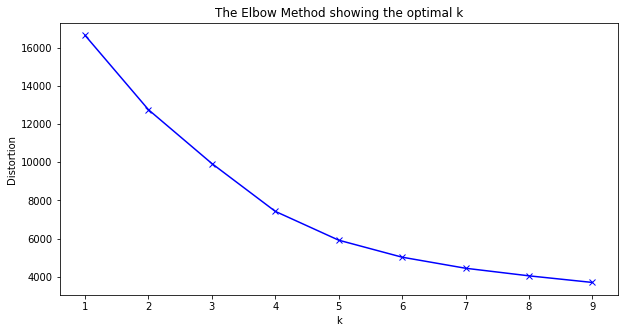

In [90]:
feature_cols2 = ['missing_po_pct',
       'same_cust_phone_trip_pct', 'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct',
        'swipe_abuse_trip_pct', 
        'return_abuse_trip_pct', 
        'scan_abuse_trip_pct',
        'multi_drop_abuse_trip_pct',
        'prop_22_abuse_trip_pct', 
        'shop_n_deliver_nil_pick_abuse_trip_pct']

data = df[feature_cols2]

distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    distortions.append(kmeans.inertia_)   # sum of squared distances to closest centroid for all observations

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [224]:
feature_cols2 =   ['missing_po_pct',
       'same_cust_phone_trip_pct', 'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct',
        'swipe_abuse_trip_pct', 
        'return_abuse_trip_pct', 
        'scan_abuse_trip_pct',
        'multi_drop_abuse_trip_pct',
        'prop_22_abuse_trip_pct', 
        'shop_n_deliver_nil_pick_abuse_trip_pct']

data2 = df[feature_cols2]
# scale the data
scaler2 = StandardScaler()
data2 = scaler2.fit_transform(data2)
kmeans2 = KMeans(n_clusters=4, random_state=42).fit(data2)

df['driver_group_all_features'] = kmeans2.labels_

silhouette_score_value2 = silhouette_score(data2, kmeans2.labels_, sample_size=30000, random_state=42)

print(f"silhouette score: {silhouette_score_value2}")

silhouette score: 0.8585573660761245


In [226]:
df.groupby('driver_group_all_features')['DRVR_USER_ID'].count().to_clipboard()

In [227]:
df.groupby('driver_group_all_features')[output_cols].mean().T.to_clipboard()

In [228]:
df.groupby('driver_group_all_features')[output_cols].median().T.to_clipboard()

In [229]:
# anomoly detection
labels2 = kmeans2.labels_
centers2 = kmeans2.cluster_centers_
distances2 = np.linalg.norm(data2 - centers2[labels2], axis=1)
df['distance_to_center_all_feature'] = distances2

threshold2 = np.percentile(distances2, 95)
df['anomoly_all_feature'] = df['distance_to_center_all_feature'] > threshold2

In [230]:
df[df.anomoly_all_feature].to_clipboard(index=False)

### Failed approach, supervised learning use logistic regression

In [132]:
feature_cols = ['missing_po_pct', 
       'same_cust_phone_trip_pct', 'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct']

# Split the data into features (X) and target (y)
X = df[feature_cols]
y = df["is_fraud"]

# Split data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.866909271358862
Confusion Matrix:
[[104812     14]
 [ 16078      6]]


In [133]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.859101811264577
Confusion Matrix:
[[103549   1277]
 [ 15759    325]]


In [134]:
feature_cols = ['missing_po_pct', 
       'same_cust_phone_trip_pct', 'large_pay_amt_pct', 'max_freq_amt_pct',
       'drop_after_arrived_at_store_trip_pct', 'express_accpt_trip_pct',
        'swipe_abuse_trip_pct', 
        'return_abuse_trip_pct', 
        'scan_abuse_trip_pct',
        'multi_drop_abuse_trip_pct',
        'prop_22_abuse_trip_pct', 
        'shop_n_deliver_nil_pick_abuse_trip_pct']

# Split the data into features (X) and target (y)
X = df[feature_cols2]
y = df["is_fraud"]

# Split data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

C:\Users\y0q00wv\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.866884459515342
Confusion Matrix:
[[104802     24]
 [ 16071     13]]
